In [1]:
import altair as alt
# альтаир нормально рендерится в jupyter lab
# в jupyter notebook нужно раскомментировать следующую строчку
# alt.renderers.enable('notebook')
import pandas as pd
import numpy as np

# Грузим данные
Датасет из таблицы с примерами, получен в /nlp/topic_models/experiments/bigartm/bigartm_baseline.ipynb

In [2]:
data = pd.read_csv('gb_filtered.csv')
data.head()

,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,1914,9,0.0,0.0,0.0,0.0,0.181999,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.19032
1,1999,8,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.135887,...,0.0,0.0,0.0,0.0,0.0,0.0,1.254909,0.0,0.0,0.00000
2,1999,9,0.0,0.0,0.0,0.0,13.084373,0.0,13.170598,13.548998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000
3,1999,10,0.0,0.0,0.0,0.0,15.557234,0.0,0.000000,14.143752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000
4,1999,11,0.0,0.0,0.0,0.0,20.917377,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000


In [3]:
# Косяк в датасете ленты ру
data = data[data['year'] > 1914]

In [4]:
data['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in data[['year', 'month']].values]
cols = [c for c in data.columns if c.startswith('topic')]

Преобразуем данные в long формат

In [6]:
dd = data[cols + ['date']].melt('date', var_name='topic', value_name='mentions')

In [7]:
# Это нужно для отрисовки общей суммы в полосе с селектом временного отрезка
ddt = dd[['date', 'mentions']].groupby('date').sum(axis=1)

In [8]:
display(ddt.head())
display(dd.head())

,mentions
date,
1999-08-01,7.345868
1999-09-01,148.918423
1999-10-01,166.693546
1999-11-01,209.573492
1999-12-01,247.734999


,date,topic,mentions
0,1999-08-01,topic_0,0.0
1,1999-09-01,topic_0,0.0
2,1999-10-01,topic_0,0.0
3,1999-11-01,topic_0,0.0
4,1999-12-01,topic_0,0.0


In [9]:
dd = dd[dd['mentions'] > 0]
ddt.reset_index(inplace=True)
ddt.rename(columns={'mentions':'total'}, inplace=True)

# Рисуем график

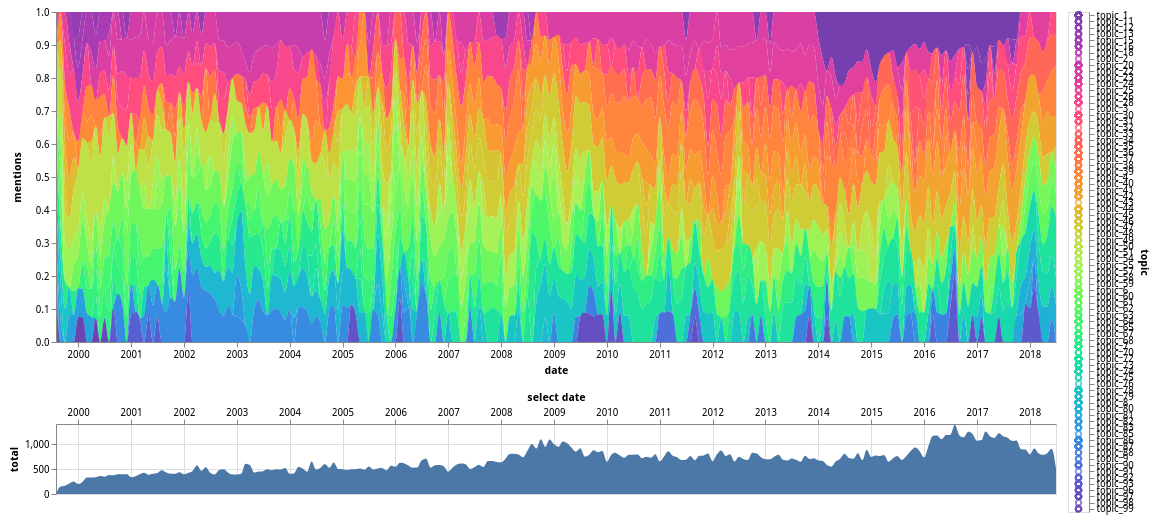

In [10]:
highlight = alt.selection(type='single',
    nearest=False, on="mouseover", fields=["topic"])

# выбор отдельных тем
selection = alt.selection_multi(fields=['topic'])

# смена цвета на выборе темы -- всё что не выделили делается серым
color = alt.condition(selection,
                      alt.Color('topic:N', legend=None,
                    scale=alt.Scale(scheme="rainbow")),
                     alt.value('lightgray'))
# выбор диапазона дат
date_sel = alt.selection_interval(encodings=["x"], empty="all", fields=["date"])



chart = alt.hconcat(
        alt.vconcat(
            # собственно stacked area
            alt.Chart(dd, height=330, width=1000)
            .mark_area(interpolate="monotone")
            .encode(
                x=alt.X("date:T"),
                y=alt.Y("mentions:Q", stack="normalize"),
                color=color,
            tooltip='topic'
            # добавляем выбор тем
            ).add_selection(selection)
            .transform_filter(date_sel),
            
            # выбор диапазона дат
            alt.Chart(ddt, height=70, width=1000)
            .mark_area(interpolate="monotone")
            .encode(
                x=alt.X("date:T",axis=alt.Axis( orient="top"),title = "select date"),
                y=alt.Y("total:Q", stack="center",)
            ).add_selection(date_sel)),
    # легенда
    alt.Chart(dd, height=500).mark_point().encode(
    y=alt.Y('topic:N', axis=alt.Axis(orient='right')),
        color=color).add_selection(selection)
    
)
chart

In [ ]:
chart.save('template.html')